In [79]:
SELF = 1
OTHER = -1
BOOM = 'BOOM'
MOVE = 'MOVE'
INF = 99.0

import numpy as np
from copy import deepcopy, copy
from random import shuffle

class State():
    def __init__(self, board=None):
        if board is None:
            self.board = np.array([
                [1, 1, 0, 0, 0, 0,-1,-1],
                [1, 1, 0, 0, 0, 0,-1,-1],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [1, 1, 0, 0, 0, 0,-1,-1],
                [1, 1, 0, 0, 0, 0,-1,-1],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [1, 1, 0, 0, 0, 0,-1,-1],
                [1, 1, 0, 0, 0, 0,-1,-1]
            ])
        else:
            self.board = deepcopy(board)
        self.turn = 0
        self.history = dd(int)

    def actions(self):
        """Return a list of the allowable moves at this point."""   
        def get_stack_actions(board, x, y):
            ''' Gets the actions of the stack at (x, y) '''
            # all pieces can boom at their position
            colour = OTHER if board[x][y] < 0 else SELF
            actions = [[BOOM, (x, y)]]
            # Moves
            height = abs(board[x][y])

            # all possible move positions on the board, including moves on to oposing pieces
            all_coords = []
            for dx in range(1, height+1):
                if 0 <= x+dx < 8:
                    all_coords.append((x+dx, y))
                if 0 <= x-dx < 8:
                    all_coords.append((x-dx, y))

            for dy in range(1, height+1):
                if 0 <= y+dy < 8:
                    all_coords.append((x, y+dy))
                if 0 <= y-dy < 8:
                    all_coords.append((x, y-dy))

            # make sure we dont move onto an opposing colour
            all_coords = [(x1, y1) for x1, y1 in all_coords if (board[x1][y1] == 0) or (board[x1][y1]*colour > 0)]

            # append all the moves with all possible number of pieces moved
            for n in range(1, height+1):
                for x_dest, y_dest in all_coords:
                    actions.append([MOVE, n, (x, y), (x_dest, y_dest)])

            return actions

        actions = []
        for x in range(8):
            for y in range(8):
                if self.board[x][y] > 0:
                    actions += get_stack_actions(self.board, x, y)
        shuffle(actions) ########################### REMOVE THIS FOR SPED ##########################
        return actions 

    def result(self, action):
        ''' Return a new state with the action taken from current state 
            MOST DEFINNITELY NEEDS TO BE FIXED
        
        '''
        
        new_board = deepcopy(self.board)
        if action[0] == MOVE:
            move, n, orig, dest = action
            x0, y0 = orig
            x1, y1 = dest
            new_board[x0][y0] -= n
            new_board[x1][y1] += n

        if action[0] == BOOM:
            def explode_recursive(board, x, y, n_explosions=0):
                ''' Returns board once explosion has occurred at coordinates '''
                # radius is a list of all board positions to blow up
                radius = [(x_, y_) for x_ in range(x-1, x+2) for y_ in range(y-1, y+2) if 0 <= x_ < 8 and 0 <= y_ < 8]
                
                # Try each position
                for x,y in radius:
                    # If there's a piece there
                    if board[x][y]:
                        n_explosions += abs(board[x][y])
                        board[x][y] = 0
                        board, n_explosions = explode_recursive(board, x, y, n_explosions)
            
                return board, n_explosions 
            
            x0, y0 = action[1]
            explode_recursive(new_board, x0, y0)
        
        r = State(new_board)
        r.turn = self.turn
        r.history = copy(self.history)
        return r


    def utility(self):
        """Return the value of this final state."""
        if self.terminal_test():
            # Draw
            if not (self.board > 0).any() and not (self.board < 0).any():
                return 0
            if (self.board > 0).any():
                return INF
            return -INF

        all_coords = [(x, y) for x in range(8) for y in range(8)]
        white_pieces = [(x, y) for x, y in all_coords if (board[x1][y1] == 0) or (board[x1][y1] > 0)]

        utility = 0
        utility +=  1  * self.board[self.board > 0].sum() / -self.board[self.board < 0].sum()

        # Distance to opponent

        # Measure of closeness or spread


        # Board position

        # Closeness to centre
        # Mobility
        utility += len(self.actions())/150

        return utility

    def terminal_test(self):
        """Return True if this is a final state for the game."""
        # not (black on board and white on board)
        return not (self.board < 0).any() or not (self.board > 0).any()

    def display(self):
        """Print or otherwise display the state."""
        print(state)

    def __repr__(self):
        return str(self)

    def __str__(self):
        return '#' + '\n#'.join([''.join([str(space).rjust(3) for space in row]) for row in self.board])


    '''
    def play_game(self, *players):
        """Play an n-person, move-alternating game."""
        state = self.initial
        while True:
            for player in players:
                move = player(self, state)
                state = self.result(state, move)
                if self.terminal_test(state):
                    self.display(state)
                    return self.utility(state, self.to_move(self.initial))
    '''

    
class BasePlayer:
    def __init__(self, colour):
        self.colour = colour
        self.state = State()
        
    def action(self):
        possible_actions = self.state.actions()
        from random import choice
        return self.format_action(choice(possible_actions))

    def update(self, colour, action):    
        self.state = self.state.result(action) 
        self.turn += 1
        
        # invert the sign of the pieces so that positive has the next move
        self.state.board = -1*self.state.board

    def format_action(self, action):
        if action[0] == BOOM:
            move, orig = action
            statement = (BOOM, orig)
        else:
            move, n, orig, dest = action
            statement = (MOVE, n, orig, dest)
        return statement


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as dd

INF = 99.0
MAX_TURNS = 250

def Φ(state):
    X, O = 1, 0
    board = state.board
    opp_b = State(-1*board).board
    all_coords = [(x, y) for x in range(8) for y in range(8)]
    X_stacks = [(x, y) for x, y in all_coords if board[x][y] > 0]
    O_stacks = [(x, y) for x, y in all_coords if board[x][y] < 0]

    def pieces(player):
        if player == X:
            return (board[board > 0].sum() - 6)/6
        return (-board[board < 0].sum() - 6)/6
    
    def stacks(player):
        if player == X:
            return ((board > 0).sum() -6)/6
        return ((board < 0).sum() - 6)/6
    
    def actions(player):
        if player == X:
            return (len(State(board).actions()) - 60)/60
        return (len(State(opp_b).actions()) - 60)/60
    
    def connectivity(player):
        player_stacks = X_stacks if player == X else O_stacks
        colour = 1 if player == X else -1
        adj = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
        
        count = 0
        s = set()
        for x, y in player_stacks:
            for d in adj:
                dx, dy = x+d[0], y+d[1]
                if 0 <= dx < 8 and 0 <= dy < 8:
                    if board[dx][dy]*colour > 0:
                        s.add((dx, dy))
        return (len(s) - 6)/6
            
    def threat(player):
        player_stacks = X_stacks if player == X else O_stacks
        colour = 1 if player == X else -1
        adj = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
        
        count = 0
        s = set()
        for x, y in player_stacks:
            for d in adj:
                dx, dy = x+d[0], y+d[1]
                if 0 <= dx < 8 and 0 <= dy < 8:
                    if board[dx][dy]*colour < 0:
                        s.add((dx, dy))
        return (len(s) - 6)/6
            
    # Distance to opponent
    # Measure of closeness or spread
    # Board position
    # Closeness to centre
    functions = [pieces, stacks, actions, connectivity, threat]
    return np.array([f(player) for player in [X, O] for f in functions] +
                    [f(X) - f(O) for f in functions])

def H(s, θ):
    h = np.dot(Φ(s), θ)
    if h > 0.99*INF:
        return 0.99*INF
    if h < -0.99*INF:
        return -0.99*INF
    return h

α = 0.00001
MAX_CHANGE = 0.1
def tree_strap_train(θ, depth=2):
    state = State()
    random_turns = 0#np.random.choice([0] + [2]*2 + [4]*4 + [8]*8 + 16*[16] + 32*[32])
    
    while (not state.terminal_test()) and (state.history[str(state)] < 4) and (state.turn < MAX_TURNS*2):
        #print(f'Turn number {state.turn}')
        #print(state)
        #print()

        state.history[str(state)] += 1

        if state.turn < random_turns:
            state = state.result(state.actions()[np.random.choice([i for i in range(len(state.actions()))])])
        else:
            searched_states = []
            V = minimax(State(state.board), depth, θ, searched_states)
            # REMOVED THIS LINE HERE, MINIMAX IS ALREADY APPENDING THAT BOI
            
            Δθ = np.zeros(len(Φ(State())))
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
                #print(α*𝛿*Φ(s))
                s.board *= -1
                𝛿 = -(vs - hs)
                Δθ += α*𝛿*Φ(s)
                #print(α*𝛿*Φ(s))
            
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for a in state.actions():
                child = state.result(a)
                #print(child)
                #print(-minimax(State(child.board*-1), depth-1, θ))
                # Put negative in front of minimax here
                actions.append((-minimax(State(child.board*-1), depth-1, θ), a))
                
            state = state.result(max(actions)[1])
        
        state.board *= -1       
        state.turn += 1
    return θ

def minimax(state, depth, θ, searched_states=None):
    if state.terminal_test():
        return state.utility()
    if depth == 0:
        return H(state, θ)

    maxEval = -INF
    for a in state.actions():
        child = state.result(a)
        child.turn += 1
        child.history[str(child)] += 1
        maxEval = max(maxEval, -minimax(State(-1*child.board), depth-1, θ, searched_states))
    
    if searched_states is not None:
        # Store the state, it's V(s) and H(s)
        searched_states.append((state, maxEval, H(state, θ)))
    return maxEval

In [95]:
θ = np.array([ -0.11318994,  0.16952328, -0.19796998,  0.20331279, -0.32902621,
                0.27450595,  0.55227518, -0.02841208, -0.20458372, -0.38016493,
                0.10028165,  0.01575708,  0.26279939, -0.34386021, -0.01015079])
θs = [np.copy(θ)]

In [102]:
θ

array([-0.11318994,  0.16952328, -0.19796998,  0.20331279, -0.32902621,
        0.27450595,  0.55227518, -0.02841208, -0.20458372, -0.38016493,
        0.10028165,  0.01575708,  0.26279939, -0.34386021, -0.01015079])

In [101]:
i = 0
while True:
    print(i, end=' ')
    θ = tree_strap_train(θ)
    θs.append(np.copy(θ))
    i += 1

0 1 

KeyboardInterrupt: 

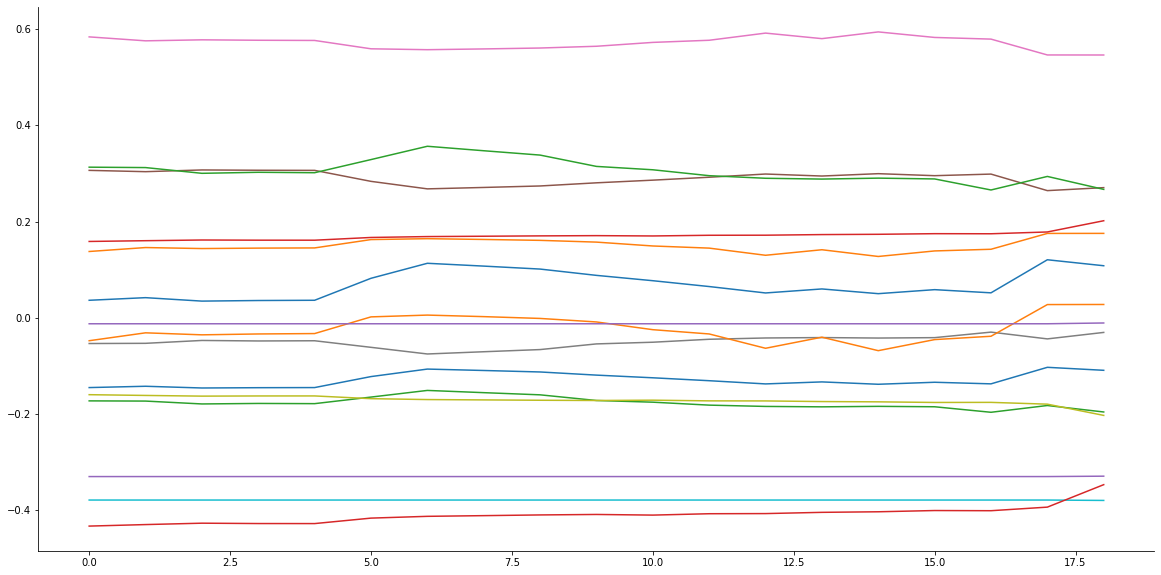

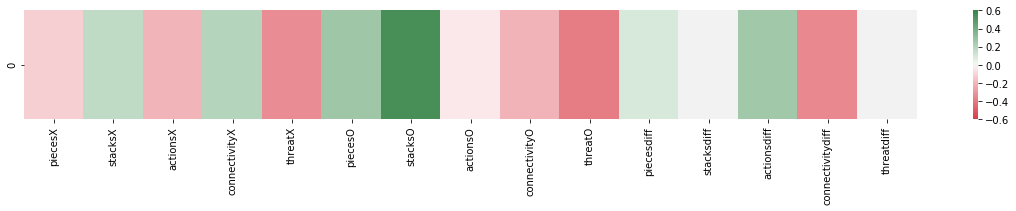

In [103]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

FACTOR=0.6
cmap = sns.diverging_palette(10, 133, as_cmap=True)
functions = ['pieces', 'stacks', 'actions', 'connectivity', 'threat']
lbls = [f + player for player in ['X', 'O'] for f in functions] + [f + 'diff'for f in functions]

fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()

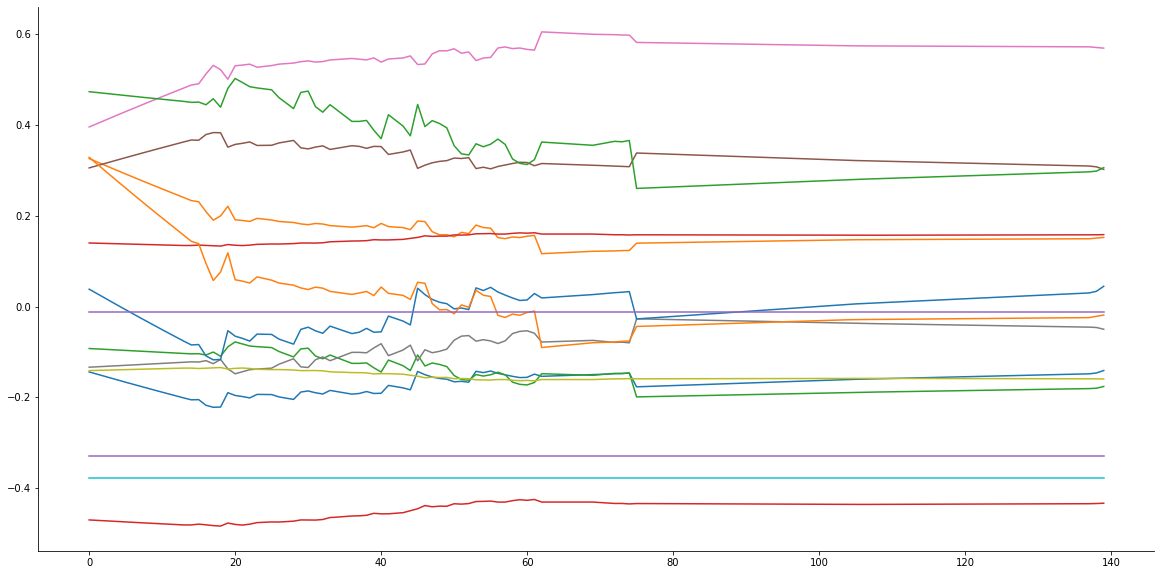

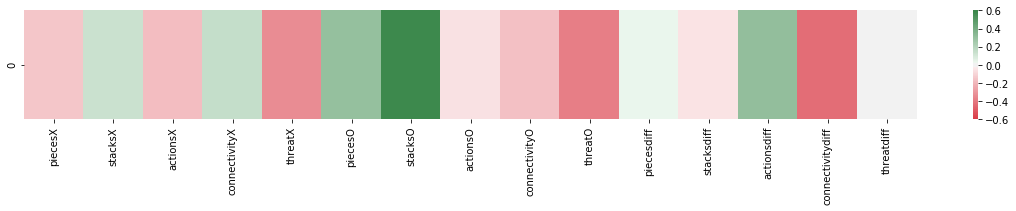

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

FACTOR=0.6
cmap = sns.diverging_palette(10, 133, as_cmap=True)
functions = ['pieces', 'stacks', 'actions', 'connectivity', 'threat']
lbls = [f + player for player in ['X', 'O'] for f in functions] + [f + 'diff'for f in functions]

fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()